In [4]:
from mpc import *

In [5]:
# Total simulation time 24h (1440m)
total_time = 1440  

# Sample time 1m
t_step = 1

# Number of control step total_time/t_step: 1440
steps = int(total_time/t_step) 

# Get average trajectory every 240 m
avg_period = 240  

# Initial conditions
x_0 = np.array([30, 50, 400, 125, 0, 0])

# References
LacI_ref = 750
TetR_ref = 300


# Dynamic Model

This function defines the mathematical model for the toggle switch in the form of differential equations with uncertain parameters.

In [6]:
def template_model(LacI_ref = 750, TetR_ref = 300):

    model = do_mpc.model.Model(model_type='continuous')

    ## Model states
    mRNA_LacI = model.set_variable(var_type='states', var_name='mRNA_LacI')
    mRNA_TetR = model.set_variable(var_type='states', var_name='mRNA_TetR')
    lacI = model.set_variable(var_type='states', var_name='LacI')
    tetR = model.set_variable(var_type='states', var_name='TetR')
    v1 = model.set_variable(var_type='states', var_name='v1')
    v2 = model.set_variable(var_type='states', var_name='v2')

    # Model inputs
    aTc = model.set_variable(var_type='inputs', var_name='aTc')
    iptg = model.set_variable(var_type='inputs', var_name='IPTG')

    # Model parameters
    k_m0_L = 3.20e-2
    k_m0_T = 1.19e-1
    k_m_L = 8.30
    k_m_T = 2.06
    k_p_L = 9.726e-1
    k_p_T = 9.726e-1
    g_m_L = 1.386e-1
    g_m_T = 1.386e-1
    g_p_L = 1.65e-2
    g_p_T = 1.65e-2
    theta_IPTG = 9.06e-2
    theta_aTc = 11.65
    eta_LacI = 2.00
    eta_TetR = 2.00
    eta_IPTG = 2.00
    eta_aTc = 2.00
    k_in_aTc = 2.75e-2
    k_out_aTc = 2.00e-2
    k_in_IPTG = 1.62e-1
    k_out_IPTG = 1.11e-1

    theta_LacI = model.set_variable(var_type='parameter', var_name='theta_LacI')  # 31.94
    theta_TetR = model.set_variable(var_type='parameter', var_name='theta_TetR')  # 30.00

    # Defining model's equations
    model.set_rhs('mRNA_LacI', k_m0_L + k_m_L*(1 / (1 + ((tetR/theta_TetR) * (1 / (1 + (v1/theta_aTc)**eta_aTc)))**eta_TetR)) - g_m_L * mRNA_LacI)
    model.set_rhs('mRNA_TetR', k_m0_T + k_m_T*(1 / (1 + ((lacI/theta_LacI) * (1 / (1 + (v2/theta_IPTG)**eta_IPTG)))**eta_LacI)) - g_m_T * mRNA_TetR)
    model.set_rhs('LacI', k_p_L * mRNA_LacI - g_p_L * lacI)
    model.set_rhs('TetR', k_p_T * mRNA_TetR - g_p_T * tetR)
    model.set_rhs('v1', (k_in_aTc * (aTc - v1)) * (aTc > v1) + (k_out_aTc * (aTc - v1)) * (aTc <= v1))
    model.set_rhs('v2', (k_in_IPTG * (iptg - v2)) * (iptg > v2) + (k_out_IPTG * (iptg - v2)) * (iptg <= v2))

    # Cost function
    model.set_expression(expr_name='cost', expr=((lacI - LacI_ref)**2 + (tetR - TetR_ref)**2))

    model.setup()

    return model


# MPC Controller

This function configure and setup the MPC controller, given the model previously defined.

Going into detail, it defines the cost function and the constraints on state variables and inputs and defines three possible values of uncertain parameters.

In [7]:
def template_mpc(model, setup_mpc):
    
    mpc = do_mpc.controller.MPC(model)

    mpc.set_param(**setup_mpc)

    # Cost function
    mterm = model.aux['cost']
    lterm = model.aux['cost']

    mpc.set_objective(mterm=mterm, lterm=lterm)
    mpc.set_rterm(aTc=1, IPTG=1)

    # Constraints
    mpc.bounds['lower', '_x', 'mRNA_LacI'] = 3.20e-2
    mpc.bounds['lower', '_x', 'mRNA_TetR'] = 1.19e-1

    mpc.bounds['lower', '_x', 'LacI'] = 0
    mpc.bounds['lower', '_x', 'TetR'] = 0

    mpc.bounds['lower', '_x', 'v1'] = 0
    mpc.bounds['lower', '_x', 'v2'] = 0

    mpc.bounds['lower', '_u', 'aTc'] = 0
    mpc.bounds['upper', '_u', 'aTc'] = 35

    mpc.bounds['lower', '_u', 'IPTG'] = 0
    mpc.bounds['upper', '_u', 'IPTG'] = 0.35

  
    theta_LacI_values = np.array([31.94, 32, 30])
    theta_TetR_values = np.array([30, 31, 29])

    mpc.set_uncertainty_values(
        theta_LacI = theta_LacI_values,
        theta_TetR = theta_TetR_values
    )
    
    mpc.setup()

    return mpc


In [8]:
def template_simulator(model, t_step):

    simulator = do_mpc.simulator.Simulator(model)
    simulator.set_param(t_step=t_step)
    p_template = simulator.get_p_template()

    def p_fun(t_now):

        p_template['theta_LacI'] = np.random.uniform(low=30, high=32)
        p_template['theta_TetR'] = np.random.uniform(low=29, high=31)

        return p_template

    simulator.set_p_fun(p_fun)

    simulator.setup()

    return simulator


## Control loop
Control loop for the uncertain model.

In [9]:
%%capture

setup_mpc = {
    'n_robust': 1,
    'n_horizon': 7,
    't_step': t_step,
    'store_full_solution': True,
}

model = template_model()
mpc = template_mpc(model, setup_mpc)
simulator = template_simulator(model, t_step)
estimator = do_mpc.estimator.StateFeedback(model)

simulator.reset_history()

mpc.x0 = x_0
simulator.x0 = x_0
estimator.x0 = x_0

mpc.set_initial_guess()

for k in range(steps):

    u = mpc.make_step(x_0)

    if (mpc.t0 - t_step) % 15 == 0:
        ukm1 = u
    else:
        u = ukm1

    y_next = simulator.make_step(u)
    x_0 = estimator.make_step(y_next)

data = save_results(mpc, avg_period, t_step)


## Compute performance metrics and plot results

------------------------------ PERFORMANCES METRICS ------------------------------
ISE: 4.15e+01
ITAE: 1.49e+05
------------------------------ PLOT RESULTS ------------------------------


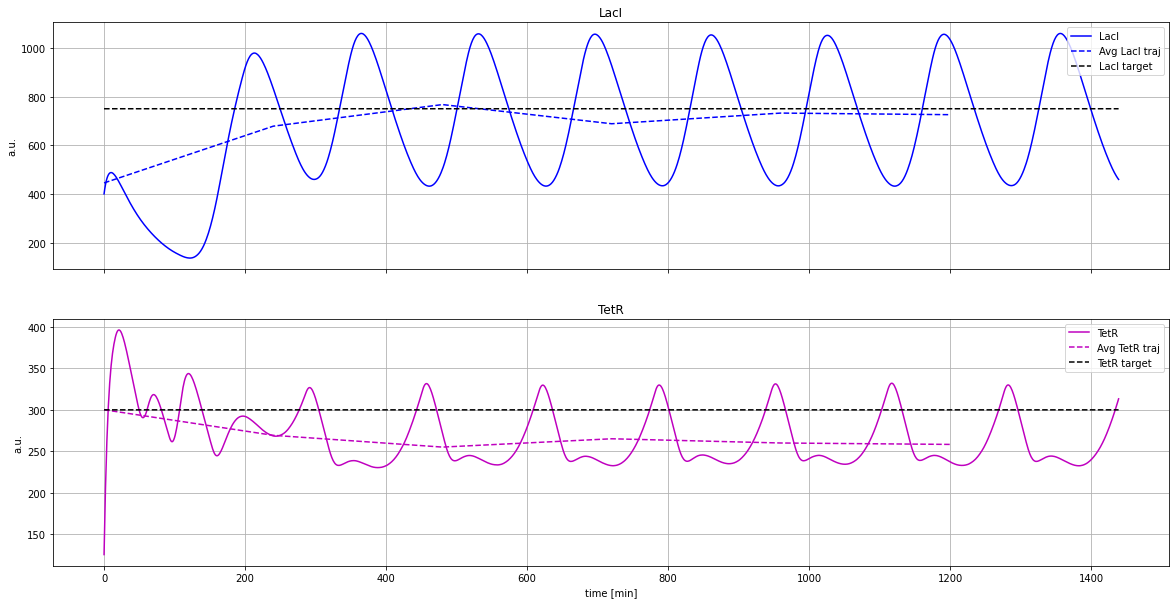

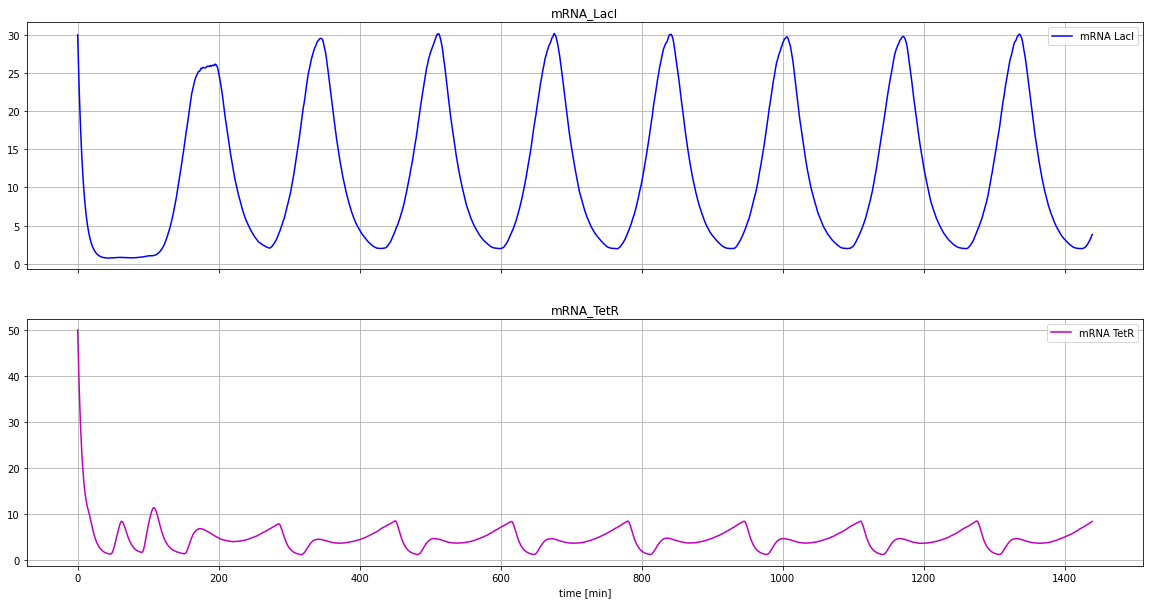

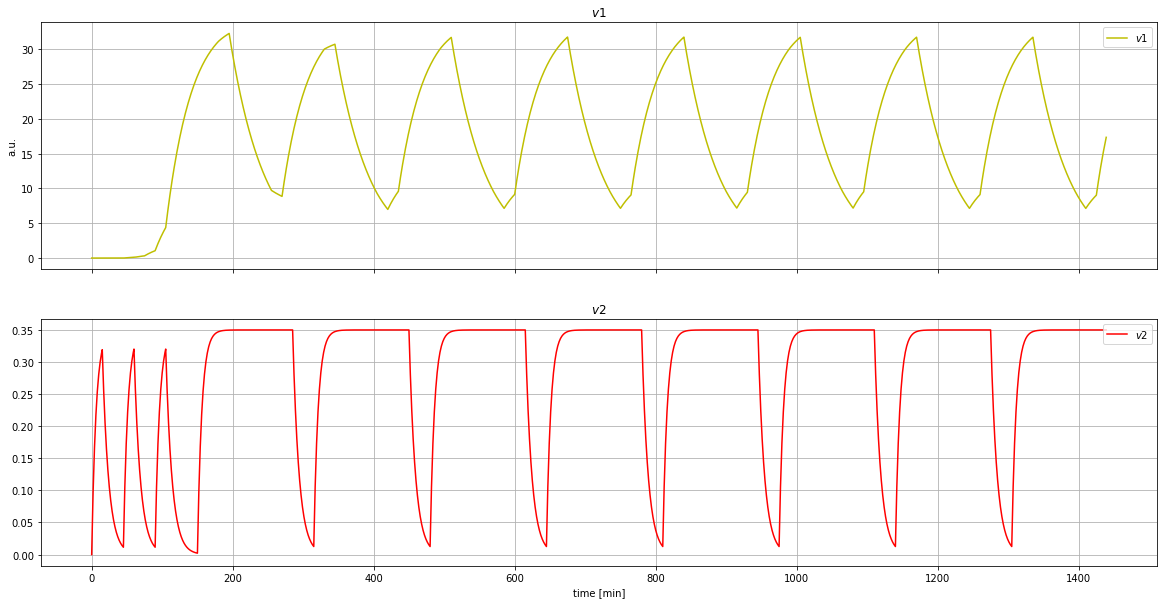

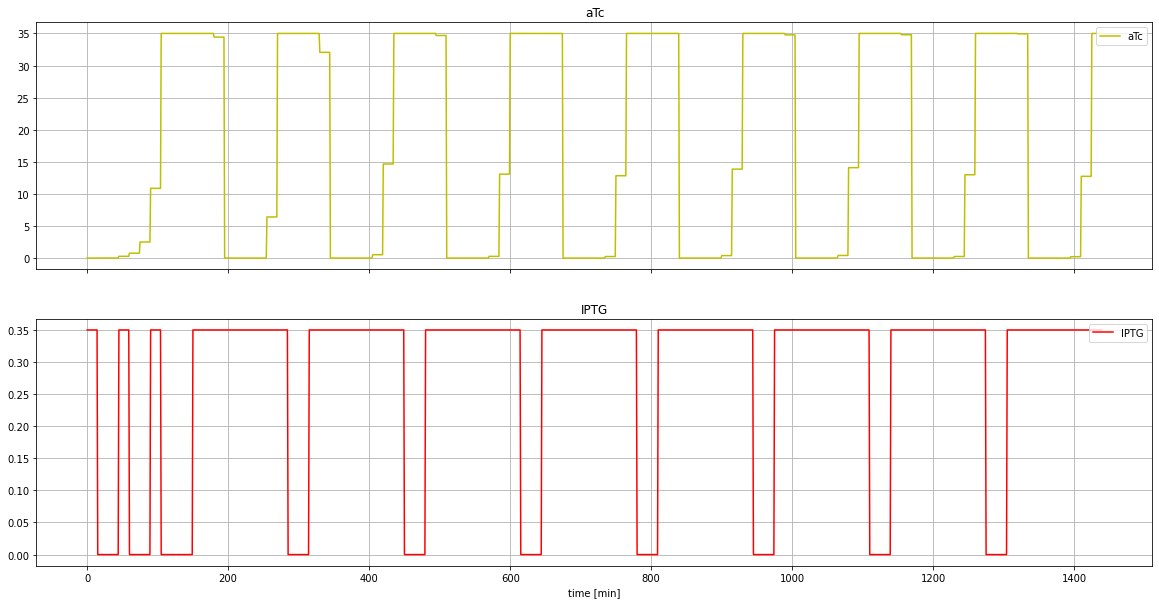

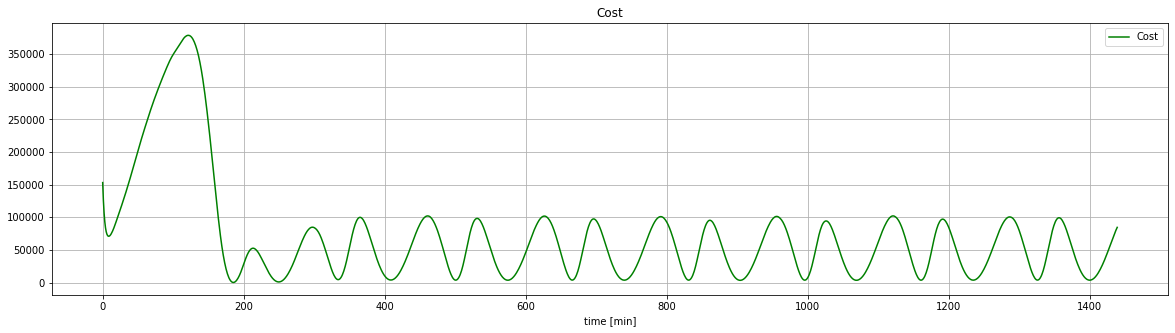

In [10]:
print('------------------------------ PERFORMANCES METRICS ------------------------------')
ISE, ITAE = compute_performance_metrics(data, total_time, t_step, avg_period, LacI_ref, TetR_ref)
print('ISE:', format(ISE, '.2e'))
print('ITAE:', format(ITAE, '.2e'))

print('------------------------------ PLOT RESULTS ------------------------------')
figures, lines = plot_results(data, total_time, avg_period,  LacI_ref, TetR_ref)

## Predictions plot
Plot the predictions of the states as the values assumed by the uncertain parameters vary.

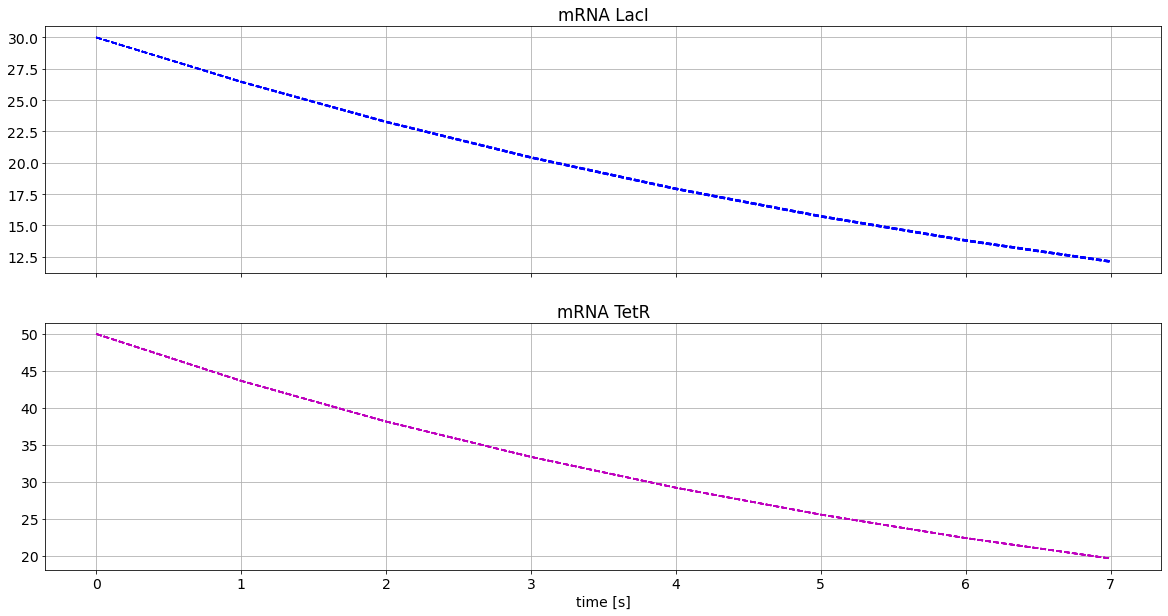

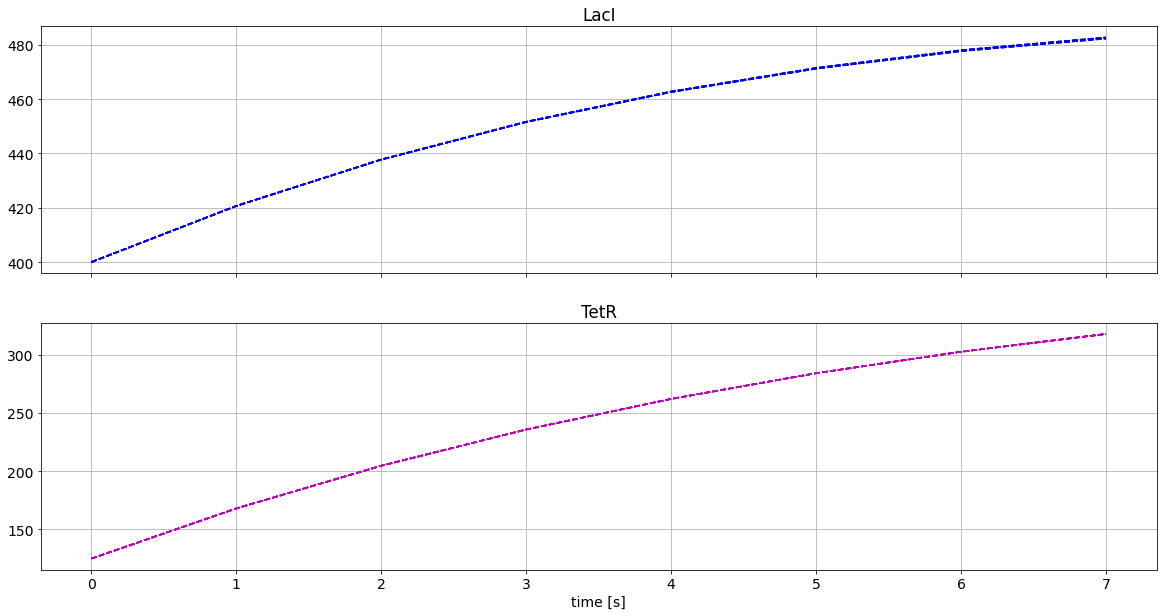

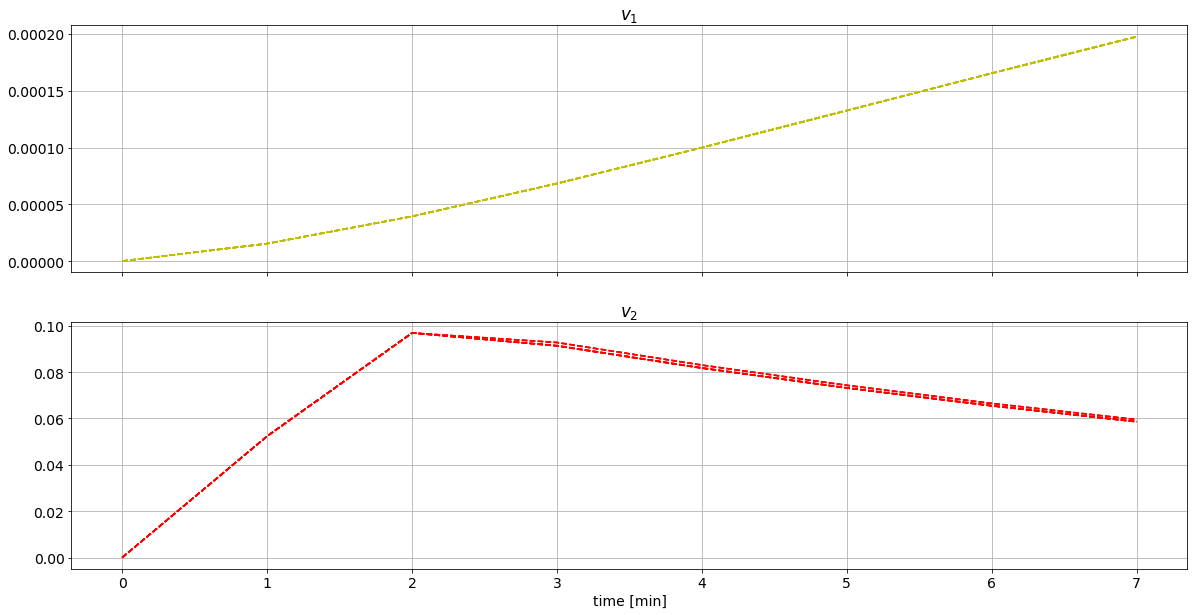

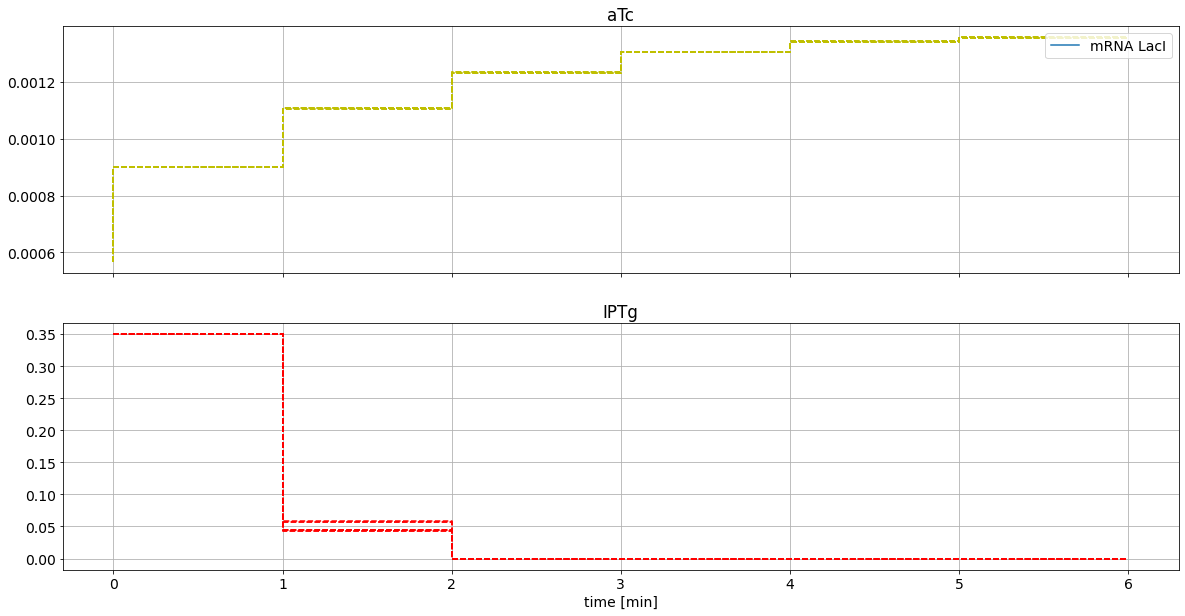

In [11]:
fig_x = 20
fig_y = 10

plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 14

mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
figure, axes = plt.subplots(2, sharex=True, figsize=(fig_x, fig_y))

mpc_graphics.add_line(var_type='_x', var_name='mRNA_LacI', axis=axes[0])
for line in mpc_graphics.pred_lines['_x', 'mRNA_LacI']: line.set_color('b')
mpc_graphics.add_line(var_type='_x', var_name='mRNA_TetR', axis=axes[1])
for line in mpc_graphics.pred_lines['_x', 'mRNA_TetR']: line.set_color('m')
axes[0].set_ylabel('')
axes[0].set_title('mRNA LacI')
axes[1].set_ylabel('')
axes[1].set_title('mRNA TetR')
axes[1].set_xlabel('time [s]')

figure, axes = plt.subplots(2, sharex=True, figsize=(fig_x, fig_y))
mpc_graphics.add_line(var_type='_x', var_name='LacI', axis=axes[0])
for line in mpc_graphics.pred_lines['_x', 'LacI']: line.set_color('b')
mpc_graphics.add_line(var_type='_x', var_name='TetR', axis=axes[1])
for line in mpc_graphics.pred_lines['_x', 'TetR']: line.set_color('m')
axes[0].set_ylabel('')
axes[0].set_title('LacI')
axes[1].set_ylabel('')
axes[1].set_title('TetR')
axes[1].set_xlabel('time [s]')

figure, axes = plt.subplots(2, sharex=True, figsize=(fig_x, fig_y))
mpc_graphics.add_line(var_type='_x', var_name='v1', axis=axes[0])
for line in mpc_graphics.pred_lines['_x', 'v1']: line.set_color('y')
mpc_graphics.add_line(var_type='_x', var_name='v2', axis=axes[1])
for line in mpc_graphics.pred_lines['_x', 'v2']: line.set_color('r')
axes[0].set_ylabel('')
axes[0].set_title('$v_1$')
axes[1].set_ylabel('')
axes[1].set_title('$v_2$')
axes[1].set_xlabel('time [min]')

figure, axes = plt.subplots(2, sharex=True, figsize=(fig_x, fig_y))
mpc_graphics.add_line(var_type='_u', var_name='aTc', axis=axes[0])
for line in mpc_graphics.pred_lines['_u', 'aTc']: line.set_color('y')
mpc_graphics.add_line(var_type='_u', var_name='IPTG', axis=axes[1])
for line in mpc_graphics.pred_lines['_u', 'IPTG']: line.set_color('r')
axes[0].set_ylabel('')
axes[0].set_title('aTc')
axes[1].set_ylabel('')
axes[1].set_title('IPTg')
axes[1].set_xlabel('time [min]')

mpc_graphics.clear()
mpc_graphics.plot_predictions(t_ind=0)
axes[0].legend(['mRNA LacI'], loc='upper right')
mpc_graphics.reset_axes()


In [12]:
export_results(data, 'uncertain', 'results', 'w')